# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal, stats
import scipy.fftpack
from cycler import cycler

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
#%matplotlib notebook

# Data structure

In [3]:
N_scal = 192
simulations = [
        {'Sc': 400.0, 'nb_sca' : 1, 'N': N_scal, 'u': 1.53, 'm' : 0.0, 'folder' : 'u153/m0/', 'runs': [828, 780], \
         'D0': 1.12E-003, 'gamma2' : 4.9930962538633841E-002, 'field_ite' : 180000, 'L' : 3.3814, 'A' : 4.469}, 
        {'Sc': 400.0, 'nb_sca' : 1, 'N': N_scal, 'u': 1.53, 'm' : 1.0, 'folder' : 'u153/', 'runs': [724, 732], \
         'D0': 2.4672760386848709E-003, 'gamma2' : 4.9930962538633841E-002, 'field_ite' : 170000, 'L' : 2.3787, 'A' : 2.0293},
        {'Sc': 400.0, 'nb_sca' : 1, 'N': N_scal, 'u': 1.53, 'm' : 2.0, 'folder' : 'u153/m2/', 'runs': [703, 772], \
         'D0': 5.5866E-003, 'gamma2' : 4.9930962538633841E-002, 'field_ite' : 180000, 'L' : 1.4117, 'A' : 0.8963},
        {'Sc': 400.0, 'nb_sca' : 1, 'N': N_scal, 'u': 1.53, 'm' : 4.0, 'folder' : 'u153/m4/', 'runs': [726, 743], \
         'D0': 1.405E-002, 'gamma2' : 4.9930962538633841E-002, 'field_ite' : 170000, 'L' : 0.7064, 'A' : 0.3562}]

In [4]:
eps = 4.0/3.0
viscosity = 1.0

In [5]:
for sim in range(len(simulations)) :
    simulations[sim].update({'diffusivity': viscosity/simulations[sim]["Sc"], 'P' : 1/simulations[sim]["gamma2"]})

# Reading data

In [6]:
#read correlation files
def read_data_file(common_folder, scalar, file_type, spec_type, spec_component, run_files) :
    nb_of_runs = len(run_files)
    for run_index in list(range(nb_of_runs)) :
        folder = common_folder + "run" + "%01d" % (run_index+1) + "/"
        if (run_files[run_index] < 1000) :
            file = folder + "scalar%01d" %scalar + "_" + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
        else : 
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
        file_data = []
        print('reading file: ' + file)
        averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (run_index == 0) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    k = np.array(accumulated_data[0])
    nb_of_modes = np.array(accumulated_data[1])
    average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
    for i in list(range(average_data.shape[0])) : 
        average_data[i, :] = np.array(accumulated_data[i+2])
    t = average_data[:,0]
    numpy_file_table = np.array(average_data[:,1:])
    return [k, nb_of_modes, t, numpy_file_table]

In [7]:
# read velocity spectrum file
def read_spec_file(common_folder, forlder_in, quantity, spec_type, ite) :
    file = common_folder + forlder_in + quantity + "_spec_" + spec_type + "_ite=%06d" % ite + ".table"
    print('reading file: ' + file)
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)  
    spec_table = np.array(file_data)
    k = spec_table[:,0]
    nb_of_modes = spec_table[:,1]
    Ek = spec_table[:,2]
    Exx = spec_table[:,3]
    Eyy = spec_table[:,4]
    Ezz = spec_table[:,5]
    #return [k, nb_of_modes, Ek, Exx, Eyy, Ezz, spec_table[:,6], spec_table[:,7], spec_table[:,8], spec_table[:,9]]
    return [k, nb_of_modes, Ek]

In [8]:
common_folder = "/home/gorbunov8a/data/random_advection/e43/N192/gamma01/"
spec_type = "lin"
spec_component = "avg"
sca = 1
file_type = "two_point_corr_complex"

In [9]:
# read data files
for simu in simulations: 
    [k, nb_of_modes, time, two_point_corr] = read_data_file(common_folder + simu['folder'], simu['nb_sca'], file_type, spec_type, spec_component, simu['runs'])
    [k_vel, nb_of_modes_vel, Ek] = read_spec_file(common_folder + simu['folder'], "", "vel", "lin", simu['field_ite'])
    simu.update({'Ek': Ek})
    simu.update({'corr': two_point_corr})
    simu.update({'t': time})
    simu.update({'dt' : time[1]-time[0]})

reading file: /home/gorbunov8a/data/random_advection/e43/N192/gamma01/u153/m0/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=828.table
reading file: /home/gorbunov8a/data/random_advection/e43/N192/gamma01/u153/m0/run2/scalar1_two_point_corr_complex_lin_Cavg_wi=780.table
reading file: /home/gorbunov8a/data/random_advection/e43/N192/gamma01/u153/m0/vel_spec_lin_ite=180000.table
reading file: /home/gorbunov8a/data/random_advection/e43/N192/gamma01/u153/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=724.table
reading file: /home/gorbunov8a/data/random_advection/e43/N192/gamma01/u153/run2/scalar1_two_point_corr_complex_lin_Cavg_wi=732.table
reading file: /home/gorbunov8a/data/random_advection/e43/N192/gamma01/u153/vel_spec_lin_ite=170000.table
reading file: /home/gorbunov8a/data/random_advection/e43/N192/gamma01/u153/m2/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=703.table
reading file: /home/gorbunov8a/data/random_advection/e43/N192/gamma01/u153/m2/run2/scalar1_two_point_corr_complex

# Parameters

In [10]:
# Plotting options
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=14)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

In [11]:
kmin = 8
kmax = np.max(k)-6
nb_of_curves = 9
step = round((kmax - kmin)/nb_of_curves)
indices_of_k_to_plot = np.arange(kmin,kmax,step, dtype=np.int16)
print(indices_of_k_to_plot)

[ 8 17 26 35 44 53 62 71 80 89]


# Velocity spectra

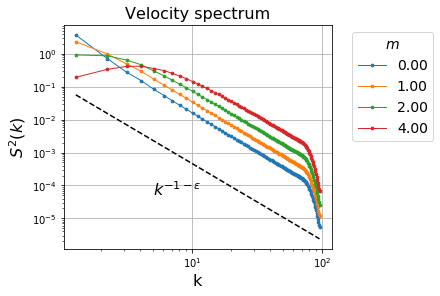

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(6,4))
#for sca in range(len(scalars)) :
for simu in simulations :
    ax.plot(k, (simu['Ek']*4.0*np.pi*(k**2)/nb_of_modes_vel), '.-', lw=1.0, markersize=5.5, label=r'%2.2f' % simu['m'])

ax.plot(k,10e-2*k**(-1-eps), 'k--'); ax.annotate(r'$k^{-1-\epsilon}$', xy=(5, 0.5e-4), xycoords='data', size='16', color='k')

ax.set(xscale='log', yscale='log', xlabel='k', ylabel=r'$S^2(k)$', title=r'Velocity spectrum'); ax.grid()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$m$', title_fontsize=14)

# pp = PdfPages('../Images/Scalar/spec_scalar_compens_eps43_N192_diff_u.pdf')
# pp.savefig(bbox_extra_artists=lgd,), bbox_inches='tight')
# pp.close()

plt.show()

In [13]:
np.sqrt(2/3*np.sum(simulations[3]['Ek']*4.0*np.pi*(k**2)/nb_of_modes_vel))

1.6238548822756405

# Scalar spectra

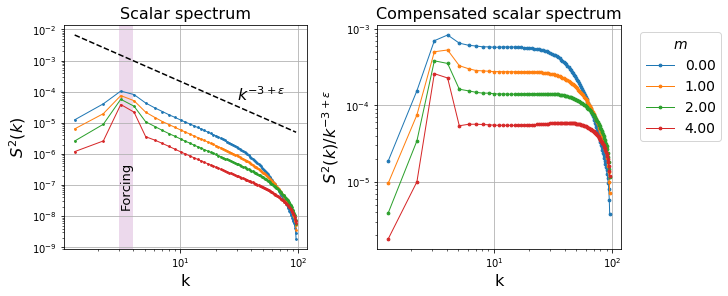

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10,4))
#for sca in range(len(scalars)) :
for simu in simulations :
    ax[0].plot(k, (simu['corr'][0,:]*4.0*np.pi*(k**2)), '.-', lw=1.0, markersize=3.5)
    ax[1].plot(k, (simu['corr'][0,:]*4.0*np.pi*(k**2))/(k**(-3+eps)), '.-', lw=1.0, markersize=5.5, label=r'%2.2f' % simu['m'])

ax[0].plot(k,10e-3*k**(-3+eps), 'k--'); ax[0].annotate(r'$k^{-3+\epsilon}$', xy=(30, 0.5e-4), xycoords='data', size='16', color='k')

ax[0].axvspan(3.0, 4.0, facecolor='purple', alpha=0.15)
ax[0].text(3.5, 10e-8, "Forcing", {'color': 'black', 'fontsize': 13},horizontalalignment='center',verticalalignment='center',rotation=90,clip_on=False)
ax[0].set(xscale='log', yscale='log', xlabel='k', ylabel=r'$S^2(k)$', title=r'Scalar spectrum'); ax[0].grid()
ax[1].set(xscale='log', yscale='log', xlabel='k', ylabel=r'$S^2(k)/k^{-3+\epsilon}$', title=r'Compensated scalar spectrum'); ax[1].grid()
#ax[1].set(ylim=[10e-7,5e-3])
lgd = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$m$', title_fontsize=14)

# pp = PdfPages('../Images/Scalar/spec_scalar_compens_eps43_N192_diff_u.pdf')
# pp.savefig(bbox_extra_artists=lgd,), bbox_inches='tight')
# pp.close()

plt.show()

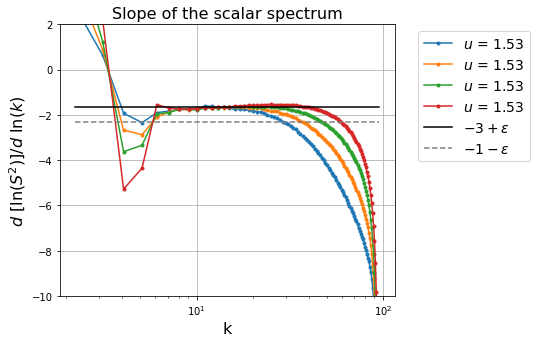

In [15]:
# check the slope of the mean energy
resampling = 1
x = np.log(k[1::resampling])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
for simu in simulations :
    slope = np.gradient(np.log((simu["corr"]*4.0*np.pi*(k**2))[0,1::resampling]), x)
    ax.plot(np.exp(x), slope, '.-', label=r'$u$ = %2.2f' % simu['u'])
ax.plot(np.exp(x), np.full_like(x, (-3.0+eps), dtype=float), 'k-', label=r'$-3+\epsilon$')
ax.plot(np.exp(x), np.full_like(x, (-1.0-eps), dtype=float), '--', label=r'$-1-\epsilon$', color='gray')

ax.set(xscale='log', yscale='linear', title='Slope of the scalar spectrum', xlabel='k', ylabel=r'$d\ [\ln(S^2)]/d\ \ln (k)$'); ax.grid()
ax.set(ylim=[-10,2])
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# pp = PdfPages('../Images/Scalar/spec_scalar_slope_eps43_N192_diff_u.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

plt.show()

# 2-point time correlations

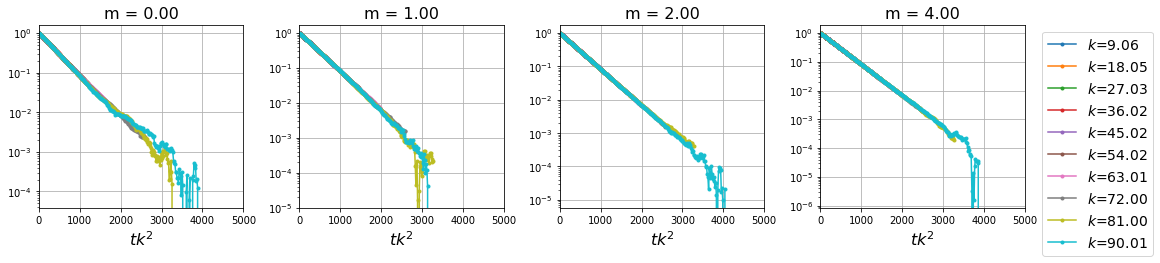

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=4, constrained_layout=True,figsize=(16,3.5), squeeze=False)
for i in range(len(simulations)) :
    simu = simulations[i]
    row = i//4; col = i - (row*4)
    corr = simu['corr']
    for ik in indices_of_k_to_plot :
        ax[row,col].plot(simu['t']*k[ik]**2, corr[:,ik]/corr[0,ik], '.-', label=r'$k$=%2.2f' % (k[ik]))
    ax[row,col].set(xscale='linear',yscale='log', xlabel=r'$t k^2$', title=r'm = %2.2f' % simu['m']); ax[row,col].grid()
    ax[row,col].set(xlim=[0,5000])
ax[0,3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Fit

In [17]:
min_coef = 5

In [18]:
def find_best_fit(data_x, data_y) :
    N = len(data_x)
    Nmin = N//min_coef
    Nmax = N-5
    a = 0; b = Nmax
    min_slope, min_intercept, r_value, p_value, min_error = stats.linregress(data_x, data_y)
    min_param = min_error/len(data_x)
    if (Nmin > 0) :
        #for i in list(range(0, N-Nmin-1)) :
        i = 0 
        for j in list(range(i+Nmin, Nmax)) :
            new_slope, new_intercept, r_value, p_value, new_error = stats.linregress(data_x[i:j], data_y[i:j])
            new_param = new_error/len(data_x[i:j])
            if (new_param < min_param) :
                min_param = new_param
                min_error = new_error; min_slope = new_slope; min_intercept = new_intercept
                a = i; b = j
    return min_slope, min_intercept, min_error, (b-a+1), a, b

In [19]:
def find_all_fits(data_x, data_y) :
    N = len(data_x)
    Nmin = N//min_coef
    Nmax = N-5
    all_slope = np.zeros(Nmax-Nmin); all_intercept = np.zeros(Nmax-Nmin); all_error = np.zeros(Nmax-Nmin)
    if (Nmin > 0) :
        #for i in list(range(0, N-Nmin-1)) :
        i = 0 
        for index, j in np.ndenumerate(list(range(i+Nmin, Nmax))):
            all_slope[index], all_intercept[index], r_value, p_value, all_error[index] = stats.linregress(data_x[i:j], data_y[i:j])
    return [all_slope, all_intercept, all_error]

In [20]:
tk2_end_fit =  1000.0
for simu in simulations :
    N = len(simu['t']); Nmin = N//min_coef; Nmax = N-5
    simu['lin_trend'] = np.zeros_like(k, dtype=float)
    simu['intercept'] = np.zeros_like(k, dtype=float)
    simu['std_error'] = np.zeros_like(k, dtype=float)
    simu['lin_trend_all'] = np.zeros((len(k), Nmax-Nmin), dtype=float)
    simu['intercept_all'] = np.zeros((len(k), Nmax-Nmin), dtype=float)
    simu['std_error_all'] = np.zeros((len(k), Nmax-Nmin), dtype=float)
    a = 0 
    b = np.searchsorted(simu['t']*k[ik]**2, tk2_end_fit)
    if (b == 0) : b = Nmax
    for ik in list(range(len(k))) : 
#         simu['lin_trend'][ik], simu['intercept'][ik], r_value, p_value, simu['std_error'][ik] = \
#         stats.linregress(simu['t'][a:b], np.log(simu['corr'][a:b,ik]/simu['corr'][0,ik]))
        simu['lin_trend'][ik], simu['intercept'][ik], simu['std_error'][ik], N, x0, x1 = find_best_fit(simu['t'][a:b], np.log(simu['corr'][a:b,ik]/simu['corr'][0,ik]))
#        simu['lin_trend'][ik], simu['intercept'][ik], simu['std_error'][ik], N, a, b = find_best_fit(simu['t'], np.log(simu['corr'][:,ik]/simu['corr'][0,ik]))
        [simu['lin_trend_all'][ik,:], simu['intercept_all'][ik,:], simu['std_error_all'][ik,:]] = find_all_fits(simu['t'], np.log(simu['corr'][:,ik]/simu['corr'][0,ik]))

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


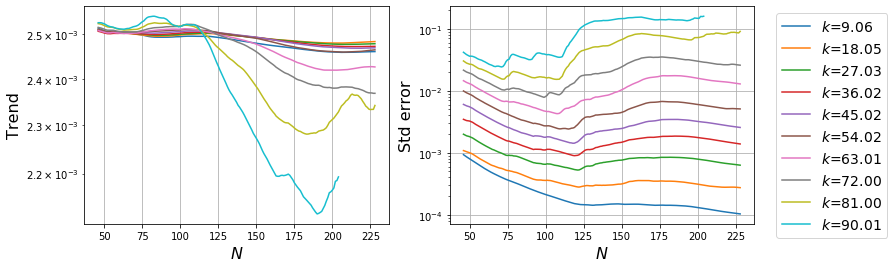

In [21]:
simu = simulations[0]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
for ik in indices_of_k_to_plot :
    N = len(simu['t']); Nmin = N//min_coef; Nmax = N-5
    x = np.arange(Nmin,Nmax)
    ax[0].plot(x, -simu['lin_trend_all'][ik,:]/k[ik]**2, label=r'$k$=%2.2f' % (k[ik]))
    ax[1].plot(x, simu['std_error_all'][ik,:], '-', label=r'$k$=%2.2f' % (k[ik]))
ax[0].set(xlabel=r'$N$', ylabel='Trend', yscale='log'); ax[0].grid()
ax[1].set(xlabel=r'$N$', ylabel='Std error', yscale='log'); ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

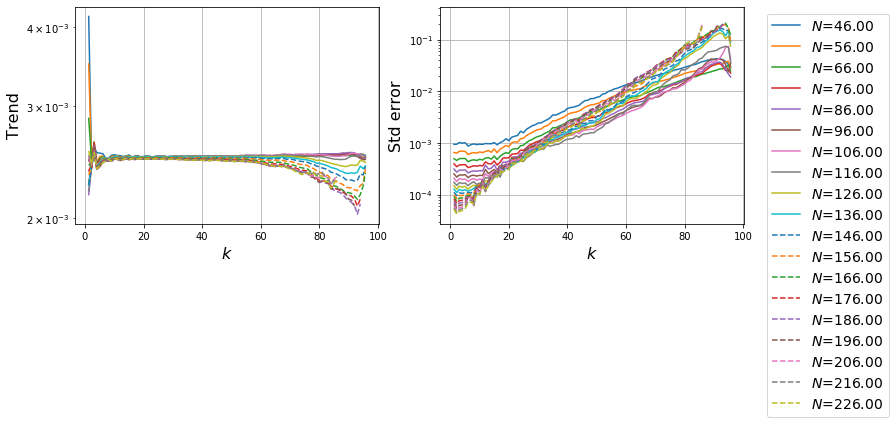

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
N = len(simu['t']); Nmin = N//min_coef; Nmax = N-5
for iN in np.arange(0,Nmax-Nmin,10) :
    ax[0].plot(k, -simu['lin_trend_all'][:,iN]/k**2, label=r'$N$=%2.2f' % (Nmin + iN))
    ax[1].plot(k, simu['std_error_all'][:,iN], label=r'$N$=%2.2f' % (Nmin + iN))
ax[0].set(xlabel=r'$k$', ylabel='Trend', yscale='log'); ax[0].grid()
ax[1].set(xlabel=r'$k$', ylabel='Std error', yscale='log'); ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [23]:
# # min error (max points - ? )
# for simu in simulations :
#     N = len(simu['t']); Nmin = N//min_coef; Nmax = N-5
#     simu['number_of_points_in_fit'] = np.zeros_like(k, dtype=float)
#     for ik in list(range(len(k))) : 
#         iN = np.nanargmin(simu['std_error_all'][ik,:]/(Nmin + iN))
#         simu['number_of_points_in_fit'][ik] = Nmin + iN
#         #rint(iN)
#         simu['lin_trend'][ik] = simu['lin_trend_all'][ik,iN]
#         simu['intercept'][ik] = simu['intercept_all'][ik,iN]; 
#         simu['std_error'][ik] = simu['std_error_all'][ik,iN]; 

In [24]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
# N = len(simu['t']); Nmin = N//min_coef; Nmax = N-5
# for simu in simulations :
#     ax.plot(k, simu['number_of_points_in_fit'], '.', label=r'%2.2f' % simu['u'])
# ax.set(xlabel=r'$k$', ylabel='N points', yscale='linear'); ax.grid()
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$U_{RMS}$')
# plt.show()

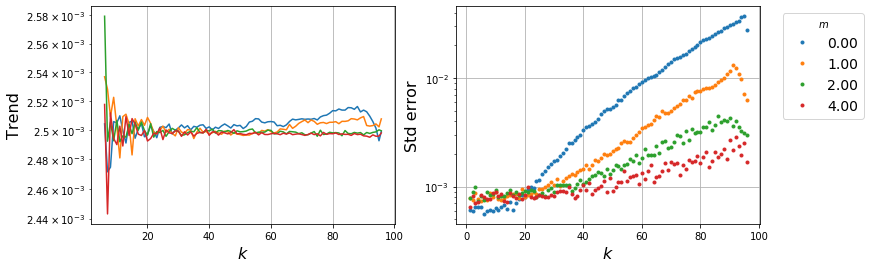

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
N = len(simu['t']); Nmin = N//min_coef; Nmax = N-5
for simu in simulations :
    ax[0].plot(k[5::], (-simu['lin_trend']/k**2)[5::])
    ax[1].plot(k, simu['std_error'], '.', label=r'%2.2f' % simu['m'])
ax[0].set(xlabel=r'$k$', ylabel='Trend', yscale='log'); ax[0].grid()
ax[1].set(xlabel=r'$k$', ylabel='Std error', yscale='log'); ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$m$')
plt.show()

# Plot results of fit

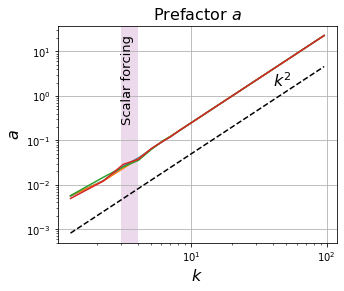

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
for simu in simulations :
    ax.plot(k, -1.0*simu['lin_trend'], '', label=r'%2.2f' % simu['u'])
ax.plot(k, 5e-4*k**2, 'k--')
ax.annotate(r'$k^2$', xy=(40, 1.6e0), xycoords='data', size='16')
ax.set(xscale='log', yscale='log', xlabel=r'$k$', ylabel=r'$a$', title='Prefactor $a$'); ax.grid()
#ax.set(ylim=[5e2,10e6])
#ax.annotate(r'diffusivity', xy=(50, 6e5),  xycoords='data', xytext=(50, 1.6e3), textcoords='data', arrowprops=dict(facecolor='black', width=0.25), size='14', horizontalalignment='center', verticalalignment='top')
plt.axvspan(3.0, 4.0, facecolor='purple', alpha=0.15)
plt.text(0.25, 0.75, "Scalar forcing", {'color': 'black', 'fontsize': 13},
         horizontalalignment='center',
         verticalalignment='center',
         rotation=90,
         clip_on=False,
         transform=plt.gca().transAxes)
#lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$U_{RMS}$', title_fontsize=12)
#ax.legend(title=r'Diffusivity $\kappa$', title_fontsize=12)

# pp = PdfPages('../Images/Scalar/corr_fit_vs_k_eps43_N192_diff_u.pdf')
# pp.savefig(bbox_extra_artists=(), bbox_inches='tight')
# pp.close()

plt.show()

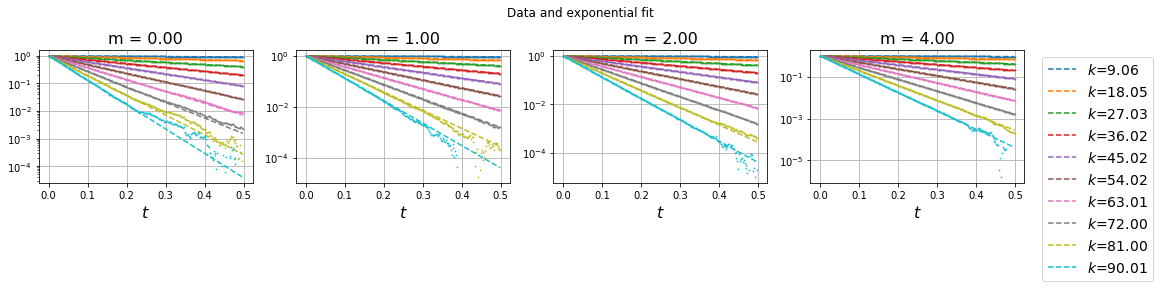

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=4, constrained_layout=True,figsize=(16,3.5), squeeze=False)
fig.suptitle('Data and exponential fit')
for i in range(len(simulations)) :
    simu = simulations[i]
    row = i//4; col = i - (row*4)
    corr = simu['corr']
    for index,ik in np.ndenumerate(indices_of_k_to_plot) :
        ax[row,col].plot(simu['t'], corr[:,ik]/corr[0,ik], '.', markersize=1.5)
        ax[row,col].plot(simu['t'], np.exp(simu['lin_trend'][ik]*simu['t']+simu['intercept'][ik]), '--', label=r'$k$=%2.2f' % (k[ik]), color=colors[index[0]])
    ax[row,col].set(xscale='linear',yscale='log', xlabel=r'$t$', title=r'm = %2.2f' % simu['m']); ax[row,col].grid()
leg = ax[0,3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# pp = PdfPages('../Images/Scalar/corr_data_and_fit_vs_D0_eps43_N192_diff_u.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

In [28]:
def find_plateau(data) :
    N = len(data)
    Nmin = N//2
    a = 0; b = N-1
    minAlign = np.max(data-np.mean(data))/np.float(b-a+1)
    for i in list(range(0, N-Nmin-1)) :
        for j in list(range(i+Nmin, N-1)) :
            newAlign = np.max(data[i:j]-np.mean(data[i:j]))/np.float(j-i+1)
            if (newAlign < minAlign) :
                minAlign = newAlign
                a = i; b = j
    return np.mean(data[a:b]), np.std(data[a:b]), (b-a+1), a, b

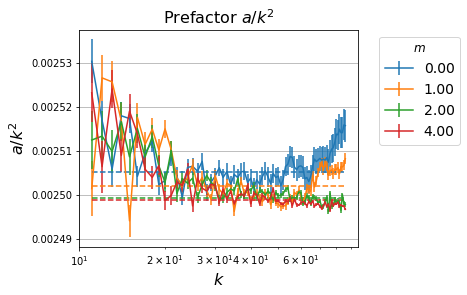

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
sl = np.s_[10:-10]
for i in range(len(simulations)) :
    simu = simulations[i]
    ydata = -1.0*(simu['lin_trend'][sl] - simu['diffusivity'])/(k[sl]**2)
    simu['plateau_a'] = find_plateau(ydata)[0]
    simu['std_err_plateau_a'] = np.sqrt(np.sum(ydata-simu['plateau_a'])**2)/len(k[sl]-1)
    ax.errorbar(k[sl], ydata, yerr=simu['std_error'][sl]/(k[sl]**2), label=r'%2.2f' % simu['m'], color=colors[i])
    ax.plot(k[sl], np.full_like(k[sl], simu['plateau_a']), '--', color=colors[i])
ax.set(xscale='log', yscale='linear', xlabel=r'$k$', ylabel=r'$a/k^2$', title='Prefactor $a/k^2$'); ax.grid()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$m$', title_fontsize=12)
#ax.legend(title=r'Diffusivity $\kappa$', title_fontsize=12)

# pp = PdfPages('../Images/Scalar/corr_fit_vs_k_comp_eps43_N192_diff_u.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

plt.show()

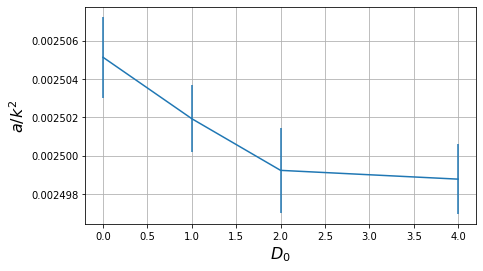

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))
x = np.array([simu['m'] for simu in simulations])
y = [simu['plateau_a'] for simu in simulations]
yerr = [simu['std_err_plateau_a'] for simu in simulations]
ax.errorbar(x,y, yerr=yerr)
ax.set(xlabel=r'$D_0$', ylabel=r'$a/k^2$'); ax.grid()

# pp = PdfPages('../Images/Scalar/corr_fit_vs_D0_eps43_N192_diff_u.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

# Compare h5 fields

In [31]:
# import h5py

# # Read scalar fields
# N_scal = 192
# scal = np.empty([N_scal, N_scal, N_scal])
# for i in list(range(len(simulations))) :
#     simu = simulations[i]
#     file = h5py.File(common_folder + simu['folder'] + 'ScalarS1_' + "%06d" % simu['field_ite'] + '.h5', 'r')
#     simu['scal_field'] = file['ScalarS1'][:,:] # copy the file data into a numpy array
#     file.close()

In [32]:
# x_scal = 2.0*np.pi/N_scal*np.arange(0,N_scal)

# nb_of_rows = 2
# nb_of_columns = 3
# table = np.arange(len(simulations)).reshape(nb_of_rows,nb_of_columns)

# fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_columns, figsize=(15,nb_of_rows*4), squeeze=False, constrained_layout=True)
# x_cut=30

# for index, isimu in np.ndenumerate(table):
#     im = ax[index].pcolormesh(x_scal, x_scal, simulations[isimu]['scal_field'][x_cut, :,:], cmap='jet')
#     ax[index].set(xscale='linear', yscale='linear', title=r'$u_{RMS} = $ %2.2f' % (simulations[isimu]['u']))
#     fig.colorbar(im, ax=ax[index], aspect=100)
#     if (index[0] == 1) : ax[index].set(xlabel=r'$y$')
#     if (index[1] == 0) : ax[index].set(ylabel=r'$z$')
# #plt.savefig("../Images/Scalar/fields_eps43_N192_diff_u.png", dpi=150, format="png")
# plt.show()